# Song popularity dataset
Predicting the popularity of a song

### Importing library's

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import math
import pandas as pd
import tensorflow as tf
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import linear, relu, softmax
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

%matplotlib widget

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)

## EDA
Exploratory data analysis

In [2]:
df = pd.read_csv("archive/song_data.csv")
df.head()

,song_name,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence
0,Boulevard of Broken Dreams,73,262333,0.005520,0.496,0.682,0.000029,8,0.0589,-4.095,1,0.0294,167.060,4,0.474
1,In The End,66,216933,0.010300,0.542,0.853,0.000000,3,0.1080,-6.407,0,0.0498,105.256,4,0.370
2,Seven Nation Army,76,231733,0.008170,0.737,0.463,0.447000,0,0.2550,-7.828,1,0.0792,123.881,4,0.324
3,By The Way,74,216933,0.026400,0.451,0.970,0.003550,0,0.1020,-4.938,1,0.1070,122.444,4,0.198
4,How You Remind Me,56,223826,0.000954,0.447,0.766,0.000000,10,0.1130,-5.065,1,0.0313,172.011,4,0.574


In [3]:
df.shape

(18835, 15)

### Delete duplicates, based on song name

In [4]:
df.drop_duplicates(subset='song_name', keep='first', inplace=True)
df.shape

(13070, 15)

Look at the composition of the dataset

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13070 entries, 0 to 18834
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   song_name         13070 non-null  object 
 1   song_popularity   13070 non-null  int64  
 2   song_duration_ms  13070 non-null  int64  
 3   acousticness      13070 non-null  float64
 4   danceability      13070 non-null  float64
 5   energy            13070 non-null  float64
 6   instrumentalness  13070 non-null  float64
 7   key               13070 non-null  int64  
 8   liveness          13070 non-null  float64
 9   loudness          13070 non-null  float64
 10  audio_mode        13070 non-null  int64  
 11  speechiness       13070 non-null  float64
 12  tempo             13070 non-null  float64
 13  time_signature    13070 non-null  int64  
 14  audio_valence     13070 non-null  float64
dtypes: float64(9), int64(5), object(1)
memory usage: 1.6+ MB


Check for null values

In [6]:
df.isnull().values.any()

False

In [7]:
# sns.pairplot(df)

### Correlation matrix

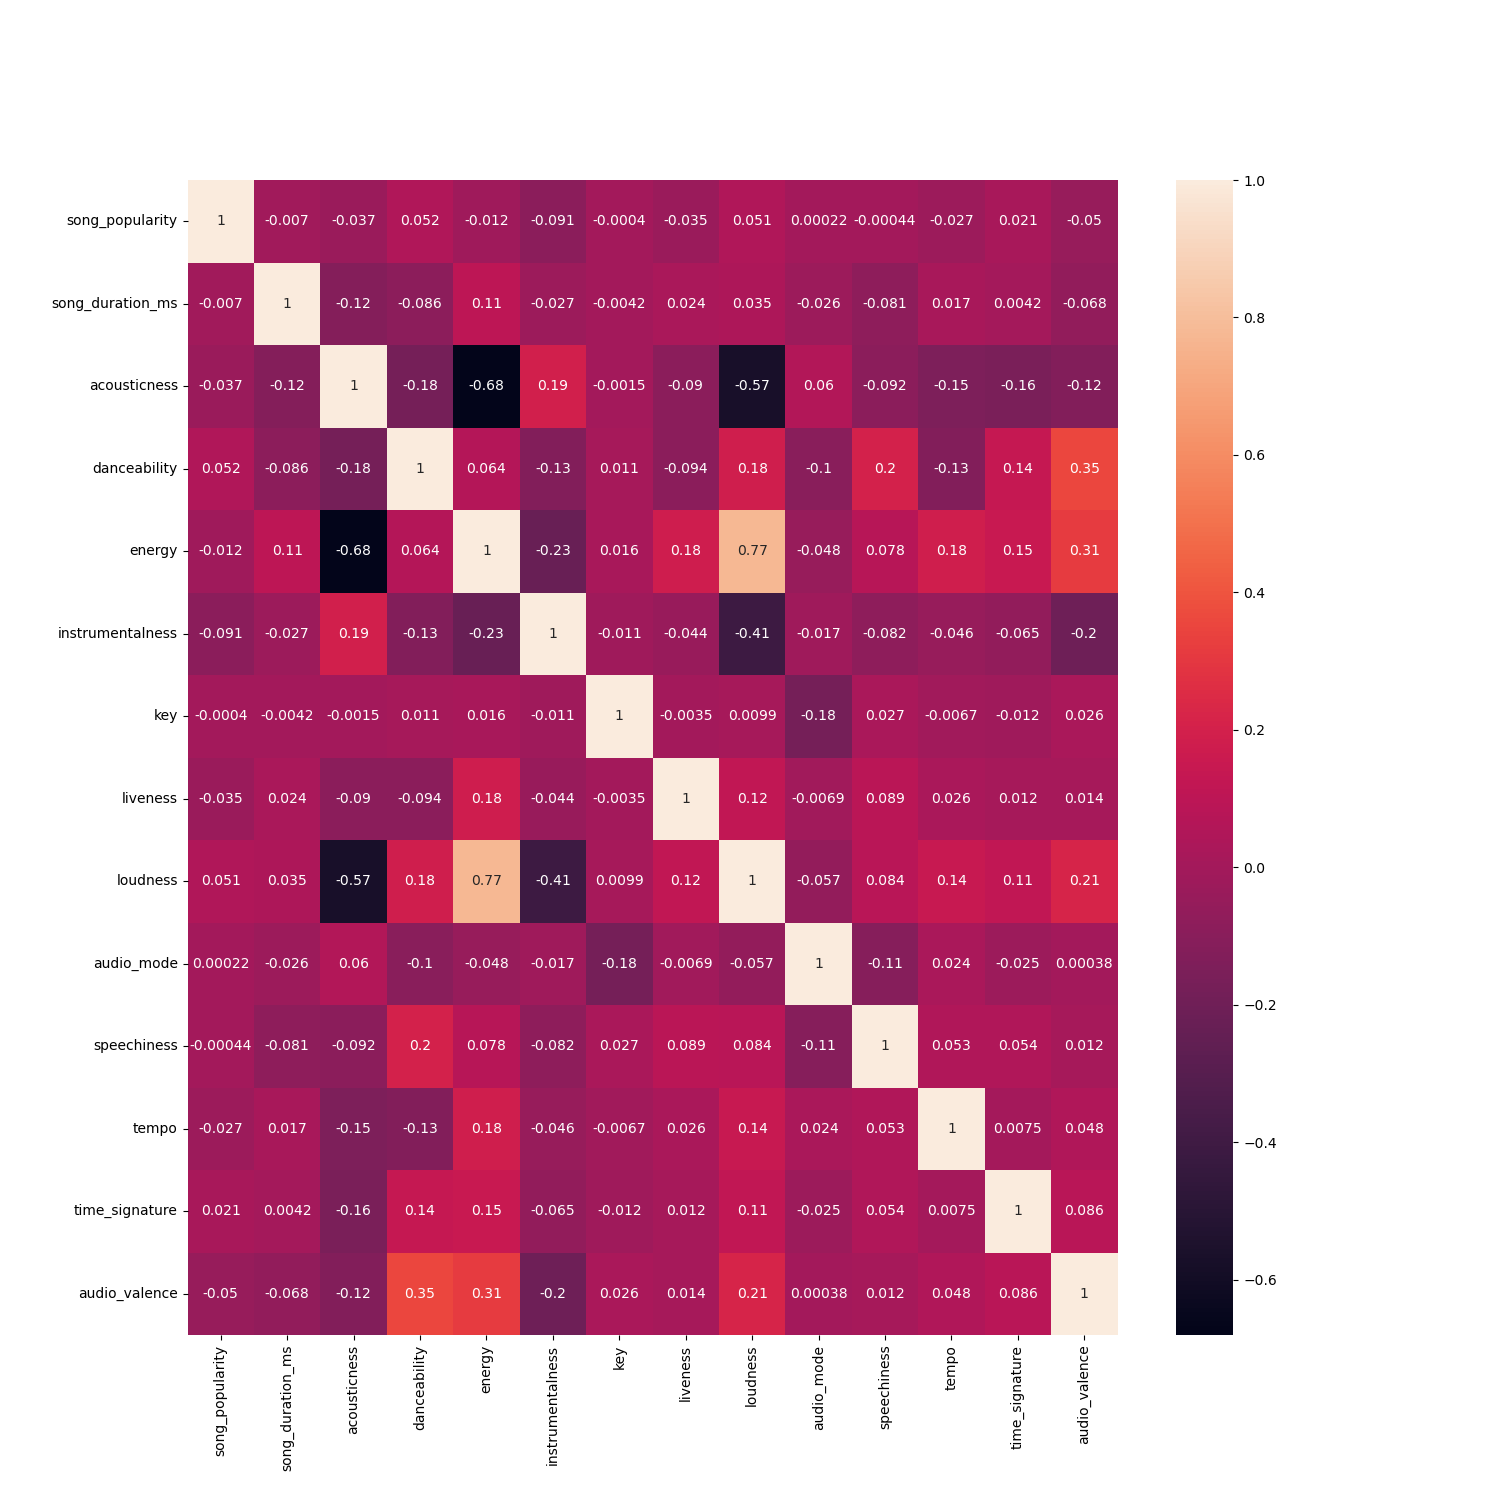

In [8]:
plt.figure(figsize=(15,15))
sns.heatmap(df.corr(),annot= True,)
plt.show()

Loudness and Energy is strong correlated, so we can drop one of them, because they give the same info to the model

In [9]:
df.drop('loudness', axis=1);

In [10]:
df.shape

(13070, 15)

In [11]:
X, y = df.drop('song_name',axis=1).to_numpy(), df['song_popularity'].to_numpy()

## Making the model

### First model trained with all data

In [154]:
model_regression = Sequential(
    [
        ### START CODE HERE ###

        #tf.keras.Input(shape=(14,)),  # specify input shape
        Dense(10, activation='relu', name="L1", kernel_regularizer=tf.keras.regularizers.l2(0.1)), # Regularization
        Dense(5, activation='relu', name="L2", kernel_regularizer=tf.keras.regularizers.l2(0.1)), # Regularization
        Dense(1, activation='linear', name="Output"),  # Linear activation for regression

        ### END CODE HERE ###
    ], name="my_regression_model"
)
model_regression.compile(
    loss='mean_squared_error', 
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
     )

In [155]:
history_regression = model_regression.fit(
    X, y,
    epochs=100
)

Epoch 1/100
409/409 [==============================] - 1s 1ms/step - loss: 369426656.0000
Epoch 2/100
409/409 [==============================] - 1s 1ms/step - loss: 53817480.0000
Epoch 3/100
409/409 [==============================] - 1s 1ms/step - loss: 3231897.7500
Epoch 4/100
409/409 [==============================] - 1s 1ms/step - loss: 50937.9414
Epoch 5/100
409/409 [==============================] - 1s 1ms/step - loss: 736.2227
Epoch 6/100
409/409 [==============================] - 1s 1ms/step - loss: 616.8869
Epoch 7/100
409/409 [==============================] - 1s 2ms/step - loss: 573.9276
Epoch 8/100
409/409 [==============================] - 1s 1ms/step - loss: 539.9020
Epoch 9/100
409/409 [==============================] - 1s 1ms/step - loss: 517.0043
Epoch 10/100
409/409 [==============================] - 1s 1ms/step - loss: 472.6887
Epoch 11/100
409/409 [==============================] - 1s 1ms/step - loss: 434.6176
Epoch 12/100
409/409 [==============================] - 1

## Second model, where dataset is divided in training data and test data

In [156]:
# using the train test split function 
X_train, X_test, y_train, y_test = train_test_split(X,y , test_size=0.4, random_state=1)
print("X_train.shape", X_train.shape, "y_train.shape", y_train.shape)
print("X_test.shape", X_test.shape, "y_test.shape", y_test.shape)

X_train.shape (7842, 14) y_train.shape (7842,)
X_test.shape (5228, 14) y_test.shape (5228,)


In [157]:
model_regression_60_40 = Sequential(
    [
        ### START CODE HERE ###

        #tf.keras.Input(shape=(14,)),  # specify input shape
        Dense(10, activation='relu', name="L1", kernel_regularizer=tf.keras.regularizers.l2(0.1)), # Regularization
        Dense(5, activation='relu', name="L2", kernel_regularizer=tf.keras.regularizers.l2(0.1)), # Regularization
        Dense(1, activation='linear', name="Output"),  # Linear activation for regression

        ### END CODE HERE ###
    ], name="my_regression_model_60_40"
)
model_regression_60_40.compile(
    loss='mean_squared_error', 
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
     )

In [158]:
early_stop= EarlyStopping(patience=20)

history_regression_60_40 = model_regression_60_40.fit(
    X_train, y_train,
    epochs=200,
    callbacks=[early_stop]
)

Epoch 1/200
246/246 [==============================] - 1s 2ms/step - loss: 30998102.0000
Epoch 2/200
246/246 [==============================] - 0s 1ms/step - loss: 307181.2500
Epoch 3/200
246/246 [==============================] - 0s 1ms/step - loss: 731.1520
Epoch 4/200
246/246 [==============================] - 0s 1ms/step - loss: 615.0948
Epoch 5/200
246/246 [==============================] - 0s 1ms/step - loss: 615.4652
Epoch 6/200
246/246 [==============================] - 0s 1ms/step - loss: 615.4285
Epoch 7/200
246/246 [==============================] - 0s 1ms/step - loss: 615.2545
Epoch 8/200
246/246 [==============================] - 0s 1ms/step - loss: 614.8157
Epoch 9/200
246/246 [==============================] - 0s 1ms/step - loss: 614.6842
Epoch 10/200
246/246 [==============================] - 0s 2ms/step - loss: 614.8822
Epoch 11/200
246/246 [==============================] - 0s 1ms/step - loss: 614.5557
Epoch 12/200
246/246 [==============================] - 0s 1ms/ste

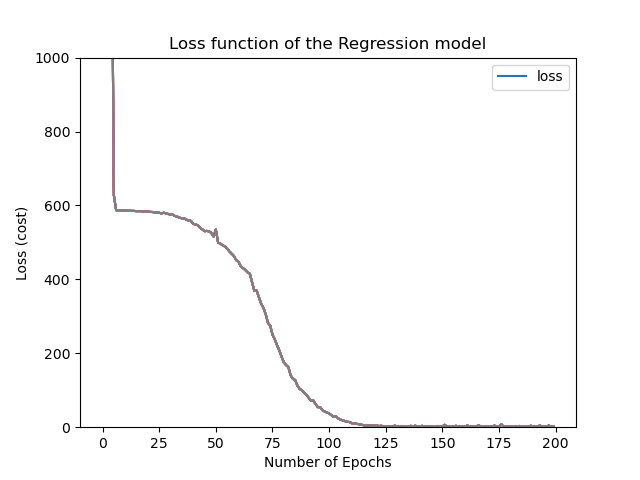

In [142]:
plt.plot(pd.DataFrame(model_regression_60_40.history.history))
plt.ylim(0, 1000)
plt.xlabel("Number of Epochs")
plt.ylabel("Loss (cost)")
plt.title("Loss function of the Regression model")
plt.show()

In [139]:
number_of_tests = 200
sum_difference = 0

for i in range(number_of_tests):
    prediction = model_regression_60_40.predict(X_test[i].reshape(1,14))
    print(f"{prediction} -> {y_test[i]}")
    sum_difference += np.power(prediction - y_test[i],2)
    
print(f"MSE: {(sum_difference/number_of_tests)[0][0]}")

1/1 [==============================] - 0s 23ms/step
[[23.285063]] -> 22
1/1 [==============================] - 0s 17ms/step
[[41.222153]] -> 40
1/1 [==============================] - 0s 15ms/step
[[71.22699]] -> 70
1/1 [==============================] - 0s 20ms/step
[[51.354]] -> 50
1/1 [==============================] - 0s 20ms/step
[[43.229042]] -> 42
1/1 [==============================] - 0s 20ms/step
[[37.85597]] -> 37
1/1 [==============================] - 0s 21ms/step
[[58.229904]] -> 57
1/1 [==============================] - 0s 9ms/step
[[71.48193]] -> 70
1/1 [==============================] - 0s 33ms/step
[[61.57264]] -> 60
1/1 [==============================] - 0s 24ms/step
[[53.146233]] -> 52
1/1 [==============================] - 0s 16ms/step
[[39.194542]] -> 38
1/1 [==============================] - 0s 17ms/step
[[47.03399]] -> 46
1/1 [==============================] - 0s 19ms/step
[[61.67783]] -> 60
1/1 [==============================] - 0s 17ms/step
[[59.568344]] -> 58
1/

## Third model, dataset divided in training data, cross-validation data and test data

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20, random_state=1)
print("X_train.shape", X_train.shape, "y_train.shape", y_train.shape)
print("X_test.shape", X_test.shape, "y_test.shape", y_test.shape)

X_train.shape (10456, 14) y_train.shape (10456,)
X_test.shape (2614, 14) y_test.shape (2614,)


In [23]:
model_regression_cross_validation = Sequential(
    [
        ### START CODE HERE ###

        #tf.keras.Input(shape=(14,)),  # specify input shape
        Dense(10, activation='relu', name="L1", kernel_regularizer=tf.keras.regularizers.l2(0.1)), # Regularization
        Dense(5, activation='relu', name="L2", kernel_regularizer=tf.keras.regularizers.l2(0.1)), # Regularization
        Dense(1, activation='linear', name="Output"),  # Linear activation for regression

        ### END CODE HERE ###
    ], name="my_regression_model_cross_validation"
)
# model_regression_cross_validation.compile(
#     loss='mean_squared_error', 
#     optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
#      )

In [27]:
# Preprocessing pipeline
preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer()),  
    ('scaler', StandardScaler())    # Standardize features
])

# Perform cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=1)

mae_scores = []

for train_index, val_index in kf.split(X_train):
    # Split the data into training and validation sets for each fold
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Clone the model to ensure a fresh instance for each fold
    model = tf.keras.models.clone_model(model_regression_cross_validation)
    model.compile(
    loss='mean_squared_error', 
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
     )

    # Create and fit the preprocessing pipeline
    X_train_fold_processed = preprocessor.fit_transform(X_train_fold)
    X_val_fold_processed = preprocessor.transform(X_val_fold)

    # Train the model
    model.fit(X_train_fold_processed, y_train_fold, epochs=100, verbose=0)
    
    number_of_tests = 200
    sum_difference = 0

    for i in range(number_of_tests):
        prediction = model.predict(X_test[i].reshape(1,14))
        print(f"{prediction} -> {y_test[i]}")
        sum_difference += np.power(prediction - y_test[i],2)
    
    print(f"MSE: {(sum_difference/number_of_tests)[0][0]}")

    # Make predictions on the validation set
    y_val_pred = model.predict(X_val_fold_processed)

    # Evaluate the model and store the MAE for this fold
    mae_fold = mean_absolute_error(y_val_fold, y_val_pred)
    mae_scores.append(mae_fold)

# Display the results
print("MAE scores for each fold:\n", mae_scores)
print("Mean MAE Score:", np.mean(mae_scores))

1/1 [==============================] - 0s 58ms/step
[[56107.55]] -> 22
1/1 [==============================] - 0s 45ms/step
[[53633.52]] -> 40
1/1 [==============================] - 0s 33ms/step
[[59147.797]] -> 70
1/1 [==============================] - 0s 23ms/step
[[62146.965]] -> 50
1/1 [==============================] - 0s 34ms/step
[[52694.805]] -> 42
1/1 [==============================] - 0s 26ms/step
[[38677.926]] -> 37
1/1 [==============================] - 0s 20ms/step
[[54069.434]] -> 57
1/1 [==============================] - 0s 29ms/step
[[67172.3]] -> 70
1/1 [==============================] - 0s 16ms/step
[[73063.734]] -> 60
1/1 [==============================] - 0s 26ms/step
[[48583.137]] -> 52
1/1 [==============================] - 0s 23ms/step
[[51551.844]] -> 38
1/1 [==============================] - 0s 22ms/step
[[39627.605]] -> 46
1/1 [==============================] - 0s 33ms/step
[[82454.49]] -> 60
1/1 [==============================] - 0s 23ms/step
[[72969.5]] -> 58

epochs is volgens mij te weinig, maar als we die zouden increasen duurt training veel langer

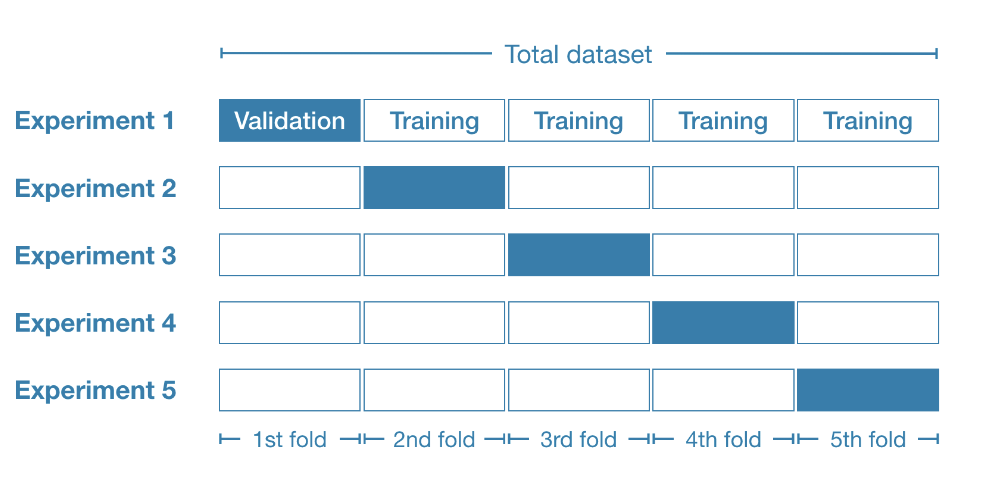

https://www.kaggle.com/code/alexisbcook/cross-validation

## Accuracy calculation

In [ ]:
Ed_IHE_Remix = X[0]
print(Ed_IHE_Remix.shape)

# Assuming 'model_regression' is the name of your regression model
prediction = model_regression.predict(Ed_IHE_Remix.reshape(1, 14))

print(f"Predicted value for regression: {prediction}")